# Clustering JGI Publications - Template

Notebook intended to provide a framework for a clustering workflow to be used with titles and abstracts of JGI-enabled publications.

The __major goal__ if this project is to see if we can thematically group a set of publications. Ideally, our groupings will be as close to reality as possible. If a subject matter expert (i.e. a plant biologist) were to look at your model's results, would that person agree with them or at least judge them to be coherent topics that *could* emerge from a group of papers in their domain?

Text analysis is useful for impact-assessment because it allows us to more efficiently summarize / categorize the scientific activities of JGI users. If we spend a lot of money on a given project, it makes sense to ask what on earth people are actually using the resulting products for. Are there counter-intuitive uses that we didn't originally think of? Do some projects lend themselves better to use cases other than those for which they were originally created? Rather than have a scientist sort through the results, we can use text analysis to get a loose idea of this picture in relatively short order.

*Note: The order below is more of a logical workflow than what actually needs to happen for your code. If you want to turn anything into standalone functions, you may want to shuffle things around. If you want to translate your code to a workable script, it will likely need to be split into various functions.*

--------------
## Imports

What packages / modules do you need? Those mentioned below are just those that I use in the current version of my workflow. Feel free to add/delete as you see fit.

Most of these are probably in the standard Anaconda distribution, but you may need to add/update certain packages.

In [1]:
# os - https://docs.python.org/3/library/os.html
# for interacting with your computer's file system
import os

#-------------------------------
# pandas - https://pandas.pydata.org/docs/user_guide/index.html
# for structuring and shaping your data
import pandas as pd
# command for Jupyter to display more than the default 50 pandas rows at once. Adjust number to preference
pd.set_option('display.max_rows', 500)

#-------------------------------
# re - https://docs.python.org/3/library/re.html
# for building custom regular expressions for use in text pre-processing
import re

#-------------------------------
# string - https://docs.python.org/3/library/string.html
# for removing punctuation and other misc. string operations during pre-processing
import string

#-------------------------------
# Natural Language Toolkit - https://www.nltk.org/
# Expansive library for working with natural language / free text data

# modules
# Stopwords corpus - https://www.nltk.org/nltk_data/
# Provides access to lists of common stopwords
from nltk.corpus import stopwords as english_stopwords
# Word tokenizer - https://www.nltk.org/api/nltk.tokenize.html
# Breaks a string into a list of substring tokens
from nltk.tokenize import word_tokenize
# lematizer - https://www.nltk.org/_modules/nltk/stem/wordnet.html
# Reduces tokens to their 'lemma' (base grammatical forms) as opposed to their stems (base form without affixes, igorant of grammatical context)
from nltk.stem import WordNetLemmatizer
# Part-of-speech tagger - https://www.nltk.org/api/nltk.tag.html
# Processes a sequence of words, and attaches a part of speech tag to each word (Used as input for lemmatizer)
from nltk import pos_tag
# Wordnet - https://www.nltk.org/howto/wordnet.html
# Used to convert pos_tag output into a form that can be used as input for the lemmatizing operation
from nltk.corpus import wordnet
# Porter Stemmer - https://www.nltk.org/_modules/nltk/stem/porter.html
# Applies the Porter-Stemming operation to tokens. Reduces words to their base, affix-less form, but loses some morphological associations
from nltk.stem import PorterStemmer

#-------------------------------
# SciKit Learn - https://scikit-learn.org/stable/
# Expansive machine learning library

# modules (algorithms) :
# Latent Dirichlet Allocation (LDA) - Not really a clustering operation. Maps topics over sets of terms, documents assigned to topics based on term-alignment with topic terms
from sklearn.decomposition import LatentDirichletAllocation
# other clustering algorithms here: https://scikit-learn.org/stable/modules/clustering.html#clustering

# modules (utilities)
# CountVectorizer - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Transforms string documents into a term-frequency (TF) matrix. (Only type of input accepted by LDA)
from sklearn.feature_extraction.text import CountVectorizer
# TFIDF Vectorizer - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# Transforms string documents into a term-frequency inverse-document-frequency (TFIDF) matrix. Many algorithms accept both TF and TFIDF, but TFIDF is more nuanced
from sklearn.feature_extraction.text import TfidfVectorizer

# sparse matrix library
# for stopword generation
from scipy.sparse import coo_array, csr_array, csc_array, csr_matrix, coo_matrix, csc_matrix
import scipy.sparse as sp

#-------------------------------
# time - https://docs.python.org/3/library/time.html
# for timing operations
from time import time

#-------------------------------
# numpy - https://numpy.org/
# for working with array formats used as input/output by certain SciKit Learn operations and accessory functions
import numpy as np

#-------------------------------
# PyLDAvis (Latent Dirchlet Allocation visualization for Python) - https://pyldavis.readthedocs.io/en/latest/readme.html
# Excellent library for visualizing the output of SciKit Learn LDA models
import pyLDAvis.sklearn

# --------------------
# Warnings - https://docs.python.org/3/library/warnings.html
# Not essential. Using this function prevents deprecation warnings, etc. from cluttering your notebook.
import warnings
warnings.filterwarnings('ignore')

import scipy

/opt/homebrew/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
from stopwords import StopwordFinder

-----------------
## Load data

Import your source data. What columns are important?

In [3]:
citations = pd.read_csv("all_soybean_citations.csv")

In [4]:
citations = citations[~citations.abstract.isna() & ~citations.title.isna()]

In [5]:
citations.columns

Index(['id', 'title', 'abstract', 'altmetric', 'authors', 'category_for',
       'category_rcdc', 'category_uoa', 'concepts_scores', 'date', 'doi',
       'funders', 'open_access', 'pages', 'reference_ids',
       'research_org_cities', 'research_org_countries',
       'research_org_country_names', 'research_orgs', 'researchers',
       'times_cited', 'type', 'volume', 'year', 'journal.id', 'journal.title',
       'research_org_state_codes', 'research_org_state_names', 'pmcid',
       'category_bra', 'issue', 'pmid', 'category_hrcs_hc', 'category_hra',
       'category_hrcs_rac', 'category_sdg', 'field_citation_ratio',
       'relative_citation_ratio', 'category_icrp_cso', 'category_icrp_ct'],
      dtype='object')

In [6]:
data = citations.copy()

Many of the above columns will be extraneous for your purposes. All of the 'category' fields are automatically derived by the data provider I use (Dimensions), so I wouldn't try to incorporate these into my models unless you've worked with the titles + abstracts and are curious as to how these other fields might affect your results. In general, I try to avoid running machine learning operations on text results derived from other automated processes, as this can add layers of abstraction that may be difficult to explain or replicate.

*Note that some steps below reference the Pandas DataFrame variable called __'data'__. In my workflow, I return a copy of my original 'citations' DataFrame after my preprocessing steps, which includes a column called 'txt' to store my processed text for each document.*

----------
## Pre-process text

What does your text need to look like to ensure that your algorithm will provide meaningful results?

__Perhaps a good first step is to ignore pre-processing altogether. Simply send your raw text to the vectorizer and see what your algorithm spits out. How does it look? What would you change?__

Some possible routes to explore:
* Noise / formatting cleanup (html tags, copyright notices, URLs, standalone punctuation/numbers, etc.)?
* Tokenization? Case-standardization (lower-casing)?
* Stopword removal?
  * General English?
  * General scientific literature? (let me know if you want me to send you my go-to list, or come up with one on your own)
  * Soybean research: domain-specific?
* Word root reduction (stemming / Lemmatization)?
* Disambuguating organism names / abbreviations? What about chemical names / abbreviations?
* Eliminating domain-specific affixes not caught by your stemmer/lemmatizer (i.e. bacterial > bacteria)?
* Dealing with word-internal punctuation?
* Weighting certain terms over others (i.e. title terms vs. abstract terms)?
* Other considerations??

*Note that the data format I use for input into the SciKit Learn vectorizers is generally a Pandas series of string values, so this is the output format I'd aim for with any pre-processing setup.*

In [7]:
txt = data.abstract

In [8]:
# Filter out html
txt = txt.str.replace(r'<[^<>]*>', '', regex=True)

In [9]:
# Filter out stopwords
txt = txt.str.replace(r'Background(?!\ )', '')
txt = txt.str.replace(r'Method(?!\ )', '')
txt = txt.str.replace(r'Title(?!\ )', '')

In [10]:
# Manually filter multigrams
txt = txt.str.replace(r'[Qq]uantitative\W[Tt]rait\W[Ll]oc[i|us]+|[Qq][Tt][Ll][sS]|[Qq][Tt][Ll]', 'QTL')
txt = txt.str.replace(r'[Ll]inkage\W*[mM]ap\w*', 'linkage_map')

In [11]:
txt.sample().values

array(['Main conclusionSoybean contains a group of 64 L-type lectin receptor-like kinases. Three LecRKs were involved in the interactions with Phytophthora sojae and Bradyrhizobium diazoefficiens.AbstractL-type lectin receptor-like kinases (LecRKs) comprise an important class of membrane-localized receptor-like kinases that are involved in plant adaptation. In this study, we performed an inventory analysis of LecRKs in Glycine max (soybean). In total, 64 GmLecRKs containing the canonical LecRK feature were identified. Phylogenetic analysis revealed that 48 GmLecRKs have close orthologs in Arabidopsis or Solanum lycopersicum, while 16 are likely present only in the leguminous plant species. Transcriptome analyses revealed that expressions of multiple GmLecRK genes\xa0are either induced or suppressed during infection by the soybean root rot pathogen Phytophthora sojae. In addition, overexpression of the three LecRKs (Glyma.17G085000, Glyma.05G041300 or Glyma.17G224600) in the soybean hai

In [12]:
# Replace all species names abbreviations with full species names, 
# Don't try to figure out this code, just trust that it was tested

def ret_match(m):
    return m.group(1) + '_' + m.group(2) if m else np.NaN

def replace_abvs(abvs, abstract):
    for k, v in abvs:
        abstract = re.sub(k, v, abstract)
    return abstract

abvs = txt.str.extractall('(([A-Z])\.\ ([a-z]\w+))').drop_duplicates()
abvs[3] = abvs.apply(lambda x: f'({x[1]}\w+) ({x[2]})', axis=1)
abvs[4] = abvs.apply(lambda x: f'({x[1]}[\w|.]+ {x[2]})', axis=1)
tmp = abvs.groupby(level=0).apply(lambda x: list(x[3])).to_frame().explode(0)
tmp[1] = txt
tmp = tmp.apply(lambda x: ret_match(re.search(x[0], x[1])), axis=1)
tmp = pd.concat([abvs[4].groupby(level=0).apply(list).explode(), tmp], axis=1).dropna()
tmp[1] = list(zip(tmp[4], tmp[0]))
tmp = pd.concat([tmp[1].groupby(level=0).apply(list), txt], join='inner', axis=1)
flt = tmp.apply(lambda x: replace_abvs(x[1], x['abstract']), axis=1)
txt.loc[flt.index] = flt

In [13]:
# lowercase
txt = txt.str.lower()

In [14]:
# filter punctuation
txt = txt.str.replace('-', ' ')
txt = txt.str.replace('\W+', ' ')

In [15]:
# split individual terms
words = txt.str.split(' ').explode()

In [16]:
words = words[words.str.contains('^[a-z]')]

In [17]:
stemmer = PorterStemmer()
words = words.apply(stemmer.stem)

In [18]:
txt = words.groupby(level=0).apply(' '.join)

In [19]:
txt

0       heat stress driven by global warm ha affect fo...
1       the combin of apomixi and hybrid product is ha...
2       the zinc defici respons in arabidopsis_thalian...
3       e3 ubiquitin ligas are known to confer abiot s...
4       pod borer helicoverpa armigera a polyphagu her...
                              ...                        
5395    transpos element are the most abund compon of ...
5397    the soybean consensu map facilit the anchor of...
5398    soybean somat embryo have attract attent both ...
5399    the number and distribut of branch in soybean ...
5400    the gener of use mutant allel of specif gene w...
Name: abstract, Length: 5293, dtype: object

In [20]:
txt.sample().values

array(['research and develop effort for biofuel product are target at convert plant biomass into renew liquid fuel major obstacl for biofuel product includ lack of biofuel crop domest low oil yield from crop plant as well as recalcitr of lignocellulos to chemic and enzymat breakdown research are expand the genet and genom resourc avail for crop improv elucid lipid metabol to facilit manipul of fatti acid biosynthet pathway and studi how plant cell wall are synthes and assembl thi knowledg will be use to produc the next gener of biofuel crop by increas fatti acid content and by optim the hydrolysi of plant cell wall to releas ferment sugar'],
      dtype=object)

--------------
## Vectorize your text data

Transform your processed text into a machine-readable, numeric array. What parameters make the most sense for your data?

The example vectorizer below is a [Count Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Another vectorizer commonly used with text data is a [TFIDF vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).  See [this site](https://scikit-learn.org/stable/modules/feature_extraction.html) for more documentation on feature extraction with SciKit Learn.

Parameters used below:
* __Maximum document frequency__. This parameter removes terms from your feature matrix that occur in more than X% of your documents. A value of .98 eliminates words that occur in more than 98% of all corpus documents. This removes noisy words that don't differentiate documents.
* __Minimum document frequency__. This parameter removes words from your feature matrix that occur in fewer than X documents in your corpus. A value of 3 eliminates words that occur in 2 or fewer documents. This removes many unique words that don't help associate documents and reduces the dimensionality (# columns) of your matrix to improve compute times.
* __NGram range__. A 'gram' is a term (column) in your frequency matrix, and an 'NGram' is a term made up of N tokens (individual words). Unigrams (N=1) consist of single tokens. Higher N values increase the number of tokens in direct proximity to one another that are strung together as single terms. Consider the phrase 'laser beam frequencies'. This phrase is made up of 3 unigrams ('laser', 'beam', 'frequencies'), 2 bigrams ('laser beam', 'beam frequencies'), and 1 trigram ('laser beam frequencies'). Your NGram range is the set of all N values you'd like to include in your feature matrix. A range of (1,1) only includes unigrams, while a range of (1-5) would generate features for unigrams, bigrams, trigrams, 4-grams, and 5-grams. Multigrams (higher than 1) contain important word associations that can be informative for your model in your specific domain context, but they also contain many useless phrases that serve only as noisy data. It is also important to consider that including multigrams drastically increases the dimensionality of your feature matrix and can slow down your model-generation process. While unigrams are crude, I find that they often lead to the best results.
* __Stopwords__. Instructs the vectorizer to eliminate features matching common stop_words (the 'english' set is used below). This is helpful to catch anything you missed in pre-processing, but not required.

*NOTE: The values used below are not final. You should adjust them as you see fit. Also, there are many other parameters you can use to adjust your vectorizer. Feel free to experiment with other parameters.*


In [175]:
%%time

# initialize your vectorizer using desired paramters. Think of this step as 'flipping the on switch' and turning some knobs
tf_vectorizer = CountVectorizer(max_df=1., # Maximum document frequency
                                min_df=3, # Minimum document frequency
                                max_features=None, # Limits the size of your array by only including the top N features by term frequency. Not used here (handy for huge datasets)
                                ngram_range=(1, 1), # NGram range
                                stop_words='english')


CPU times: user 494 µs, sys: 8 µs, total: 502 µs
Wall time: 504 µs


-----
## Automatic Stopword Detection

input a tf_matrix and txt and output stopwords

In [191]:
%load_ext autoreload
%autoreload 2
from stopwords import StopwordFinder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
%%time
stopwords = StopwordFinder(txt, tf_vectorizer)

CPU times: user 6.88 s, sys: 138 ms, total: 7.02 s
Wall time: 7.05 s


In [193]:
stopwords.semantic_entropy

array([ 0.92743244,  2.56177094, -1.18421635, ...,  4.18605638,
        1.59504601,  3.37622631])

In [194]:
stopwords.add_total(200)

In [195]:
len(stopwords.stopwords)

200

In [196]:
stopwords.add_percentile(94)

In [197]:
stopwords.features

<5293x6997 sparse matrix of type '<class 'numpy.int64'>'
	with 449838 stored elements in Compressed Sparse Row format>

In [198]:
len(stopwords.stopwords)

420

In [212]:
stopwords.keywords

['gene',
 'soybean',
 'plant',
 'genom',
 'express',
 'protein',
 'wa',
 'stress',
 'thi',
 'resist',
 'seed',
 'use',
 'identifi',
 'studi',
 'sequenc',
 'mirna',
 'nodul',
 'analysi',
 'function',
 'respons',
 'develop',
 'root',
 'drought',
 'genet',
 'regul',
 'result',
 'famili',
 'transcript',
 'toler',
 'speci',
 'acid',
 'differ',
 'crop',
 'import',
 'flood',
 'associ',
 'flower',
 'legum',
 'salt',
 'ha',
 'role',
 'high',
 'provid',
 'specif',
 'region',
 'scn',
 'oil',
 'duplic',
 'increas',
 'trait',
 'line',
 'level',
 'relat',
 'base',
 'improv',
 'breed',
 'involv',
 'select',
 'chromosom',
 'cell',
 'data',
 'includ',
 'activ',
 'content',
 'glycin',
 'molecular',
 'arabidopsi',
 'reveal',
 'mutant',
 'factor',
 'popul',
 'suggest',
 'allel',
 'pathway',
 'type',
 'genotyp',
 'compar',
 'max',
 'bean',
 'growth',
 'target',
 'indic',
 'transgen',
 'dure',
 'cultivar',
 'mechan',
 'like',
 'interact',
 'yield',
 'howev',
 'pi',
 'major',
 'process',
 'group',
 'effect',

In [211]:
stopwords.add(['qtl', 'et', 'al', 'map', 'marker', 'dna', 'rna', 'snp'])

In [202]:
stopwords.stopwords

array(['abil', 'abl', 'abscis', 'acceler', 'accord', 'achiev', 'act',
       'activ', 'adapt', 'addit', 'address', 'advanc', 'affect',
       'agricultur', 'agronom', 'aim', 'al', 'allow', 'alter', 'analys',
       'analysi', 'analyz', 'ani', 'anim', 'appear', 'appli', 'applic',
       'approach', 'approxim', 'arabidopsi', 'assess', 'assist', 'associ',
       'avail', 'averag', 'base', 'basi', 'basic', 'becaus', 'becom',
       'belong', 'benefit', 'better', 'biochem', 'bioinformat', 'biolog',
       'breed', 'breeder', 'candid', 'carri', 'caus', 'cellular',
       'certain', 'challeng', 'chang', 'character', 'characterist',
       'chromosom', 'classifi', 'clone', 'close', 'code', 'combin',
       'compar', 'comparison', 'complement', 'complet', 'complex',
       'compon', 'comprehens', 'compris', 'conclus', 'condit', 'conduct',
       'confer', 'confirm', 'conserv', 'consid', 'consider', 'consist',
       'constitut', 'construct', 'contain', 'contrast', 'contribut',
       'control',

In [203]:
stopwords.keep(['tissu'])

In [204]:
len(stopwords.stopwords)

427

In [205]:
features = stopwords.filtered_features()

In [206]:
features

<5293x6997 sparse matrix of type '<class 'numpy.float64'>'
	with 200797 stored elements in Compressed Sparse Row format>

In [207]:
etable[etable[0] < 0]

,index,0
5676,pi,-0.002700
5677,dt1,-0.002921
5678,hp,-0.009378
5679,ss2,-0.009378
5680,mpk3,-0.009378
...,...,...
6993,al,-6.680523
6994,np,-6.705578
6995,gmfad2,-6.836426
6996,melatonin,-6.885948


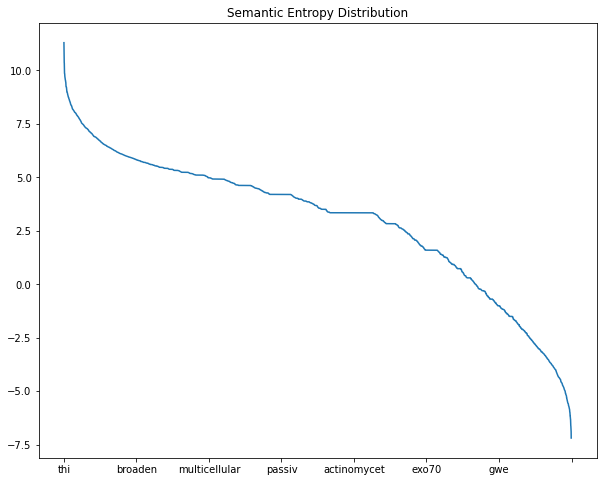

In [208]:
etable = pd.Series(stopwords.semantic_entropy,stopwords.vocabulary).sort_values(ascending=False)
etable.plot(title='Semantic Entropy Distribution', figsize=(10, 8))
etable = etable.reset_index()
etable.index = etable.index.values + 1
etable[:2000].to_html('pages/semantic_entropy.html')


--------------
## Run your algorithm

It has all led up to this moment! Here's where you get to see what the algorithms make of your processed text.

Here are some algorithms you can try (not exhaustive):
* KMeans - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* Latent Dirichlet Allocation (LDA) - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
* DBSCAN - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN
* Nonnegative Matrix Factorization (NMF) - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html. This one is actually not a clustering algorithm either, but is designed for dimensionality reduction. However it can be leveraged for clustering in the same way that LDA can. Let me know if you want to try this one and I can go dig up some sample code for making it work

|||||||||||||||||||||
### *Notes on LDA example below*

The algorithm used in the example below is called Latent Dirchlet Allocation (LDA). If you're interested, the original publication describing the algorithm is [here](https://dl.acm.org/doi/pdf/10.5555/944919.944937).

LDA isn't *actually* a clustering algorithm. It maps a series of topics over a corpus of words/documents. To leverage this tool as a clustering algorithm, you need to assign documents to topics (clusters) by looking at the "probability that a certain document belongs to a certain topic; this is based on how many words (except the current word) from this document belong to the topic of the current word." - See this [Towards Data Science page](https://towardsdatascience.com/latent-dirichlet-allocation-for-topic-modelling-explained-algorithm-and-python-scikit-learn-c65a82e7304d) for a good breakdown of what's going on when you implement LDA in SciKit Learn.

For each document, you'll end up with a series of float values denoting probabilities for association with each topic. Using some simple code, we can 'tag' our citations in our original dataframe with the topics they've been assigned to.

Parameters used below:

* Number of Components (usually called K) - How many topics/clusters do you want in your model? The ideal setting for this parameter depends on the actual trends in your data, as well as how granular you want to be in your investigation. (*There is an automated method called the 'Elbow Method' for automatically determining an optimal K value for a given dataset, but your mileage may vary as clustering is not an exact science - [short description can be found here](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a)*)
* Max iterations - How many topic reassignment iterations do you want your algorithm to perform? Higher values take longer, but can lead to more coherent topics.
* Learning method - I'm not sure about the specifics here, but 'online' (as opposed to 'batch') for this parameter lowers the compute time for larger datasets. You can read more about this with SciKit Learn's documentation.
* Random state - LDA uses random assignments in initial passes, and passing a consistent random state to the algorithm allows you to reproduce your results over multiple function calls. More on this in the documentation if you're interestred.
* Batch size - Again I'm not exactly sure on the specifics here because this is only used for the 'online' learning method. I think the basic idea is that you can control how many documents are being included in smaller samples pulled to make the iterations go faster.
* Number of Jobs - This tells the algorithm how many of your computer's workers (cores) it can occupy while running. A good rule of thumb is n - 1, where n is the number of logical cores on your computer (set to 7 below because my personal laptop has 8 logical cores). Should you move your operation to an HPC environment, this parameter becomes much more important.

*NOTE: The values used below are not final. You should adjust them as you see fit. Also, there are many other parameters you can use to adjust your algorithm, and each algorithm has different parameters. Feel free to experiment with other parameters.*


In [147]:
%%time

# initialize your algorithm using desired paramters. Think of this step as 'flipping the on switch' and turning some knobs
lda = LatentDirichletAllocation(n_components=15,           # Number of topics
                                  max_iter=50,               # Max learning iterations. LDA tries to solidify randomly assigned topics over many iterations, and this prevents 'run-away' operations and long compute times
                                  learning_method='online',  # Learning method 
                                  random_state=100,          # Random state
                                  batch_size=128,            # n docs in each learning iter
                                  n_jobs = 7,               # Use n_jobs workers
                                 )



# This is the operation that actually fits your model to your data
# It returns a matrix with X columns and Y rows, where X is your # of topics/clusters ('n_components')
# and Y is your total number of documents. Each cell contains a float probability value for a given
# document's (row) relatedness to a given topic (column)
%time lda_output = lda.fit_transform(features)

CPU times: user 12.2 s, sys: 5.06 s, total: 17.2 s
Wall time: 26 s
CPU times: user 12.2 s, sys: 5.06 s, total: 17.2 s
Wall time: 26 s


||||||||||

### *LDA Visualization Example*

I use PyLDAvis extensively every time I use LDA. It's a really handy way to get an overhead view of your terms/clusters and the relationships between them. You can read more about how it works [here](https://pyldavis.readthedocs.io/en/latest/readme.html).

[This article on PyLDAvis](https://towardsdatascience.com/topic-model-visualization-using-pyldavis-fecd7c18fbf6) is was paywalled for me, but I think you can access it with a free account. You may get some useful tips from it. [This notebook](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=), linked on the package documentation site, has a lot of handy code examples and descriptions.

Arguments used below:

* 'lda' is the variable for your initialized algorithm (not the results)
* 'features' is the variable for the sparse matrix returned by your vectorizer
* 'tf_vectorizer' if the variable for your initialized vectorizer
* 'mds' designates your multidimensional scaling method. Because the resulting visualization is displayed on a 2D plane, you have to reduce your multi-dimensional feature to something you can actually look at. There are several options here, and I don't know the specifics on how they differ, but 'tsne' has always worked well for me.

In [148]:
# Initialize your visualization.
panel = pyLDAvis.sklearn.prepare(lda, features, tf_vectorizer, mds='tsne')

/opt/homebrew/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [149]:
# Create an inline display that shows up directly in your Notebook
pyLDAvis.display(panel)



# Note that if you use this command with JupyterLab, all of your Jupyter UI buttons will disappear.
# The alternative is pyLDAvis.show(), which opens an HTML version of the visual in a new tab.
# Unfortunately the most recent version of pyLDAvis has an issue with its
# html generation, so it's probably safer to use .display() with Jupyter Notebooks instead.

In [150]:

pyLDAvis.save_html(panel, 'pages/autostops.html')

------
## Future Directions

If you get to where you are happy with your model, there are plenty of other directions in which you could take your results.

We can talk specifics on any of these (or anything you come up with on your own) when we get there, but here are some starter thoughts:

* Dynamic topic visualization. Could we build something that would allow folks to interactively explore the model you've built? What are some subtopics in each major cluster? Where are the authors of papers in that cluster coming from? What are some notable examples of papers/outcomes that are grouped in a given model?
* Connecting these models with community analysis for authors on the publications. Can we break down the authors on these papers into subcommunities? How do those subcommunities correspond or overlap with the topics/clusters from your model? Could we connect a topic visualization with a network visualization?
* Prediction. Could we explore some applications involving supervised learning on your processed data? What classes within these publications might be worth predicting? Publishing journals? Citation thresholds? High vs. low media attention?
* Change over time. How does your model look if we add in a temporal element? Are certain topics gaining/losing prominence over time?
* Proposal analysis. What does it look like if we throw the original Soybean proposal text into the mix? Can we get some idea of which papers are closely aligned with the original proposal and which papers are not?
* More publications. How widely applicable is your model? If I provided a larger, more general set of publications dealing heavily with soybean research, would you need to adjust your parameter tuning or preprocessing steps? If not, how close are the topics/clusters in the larger topic to those you generated just from those papers citing JGI's soybean genome?




